In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import fractional_matrix_power
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn import datasets


def getDistanceMatrix(data):
    """
    获取距离矩阵
    :param data: 样本集合
    :return: 距离矩阵
    """
    n = len(data)  # 样本总数
    dist_matrix = np.zeros((n, n))  # 初始化矩阵为n×n的全0矩阵
    for i in range(n):
        for j in range(i + 1, n):
            dist = np.sqrt(np.power(data[i] - data[j], 2).sum())
            dist_matrix[i][j] = dist_matrix[j][i] = dist
    return dist_matrix


def getAdjacencyMatrix(data, k):
    """
    获得邻接矩阵AdjacencyMatrix W
    :param data: 样本集合
    :param k : K参数
    :return: W
    """
    n = len(data)
    dist_matrix = getDistanceMatrix(data)
    W = np.zeros((n, n))
    for idx, item in enumerate(dist_matrix):
        idx_array = np.argsort(item)  # 每一行距离列表进行排序,得到对应的索引列表
        W[idx][idx_array[1:k + 1]] = 1
    transpW = np.transpose(W)
    return (W + transpW) / 2


def getDegreeMatrix(W):
    """
    获得度矩阵Degree
    :param W: 邻接矩阵
    :return: D
    """
    D = np.diag(sum(W))
    return D


def getLaplacianMatrix(D, W):
    """
    获得拉普拉斯矩阵
    :param W: 邻接矩阵
    :param D: 度矩阵
    :return: L
    """
    return D - W


def getEigen1(L, cluster_num):
    """
    获得拉普拉斯矩阵的特征矩阵
    cluter_num: 聚类数目
    """
    eigval, eigvec = np.linalg.eig(L)
    ix = np.argsort(eigval)[0:cluster_num]
    return eigvec[:, ix]


def getEigen2(L, D, k):
    """
    获得广义拉普拉斯矩阵的特征矩阵 Lu=λDu
    """
    DD = np.linalg.inv(D)
    L = DD @ L
    # print(L)
    eigval, eigvec = np.linalg.eig(L)
    ix = np.argsort(eigval)[0:k]
    return eigvec[:, ix]


def getEigen3(L, D, k):
    """
    获得归一化拉普拉斯矩阵的特征矩阵 Lsym
    """
    DD = fractional_matrix_power(D, -0.5)
    L = DD @ L @ DD
    # print(L)
    eigval, eigvec = np.linalg.eig(L)
    ix = np.argsort(eigval)[0:k]
    return eigvec[:, ix]

In [2]:
def get_label(data, cluster_num, type=1):
    W = getAdjacencyMatrix(data, cluster_num)
    D = getDegreeMatrix(W)
    L = getLaplacianMatrix(D, W)
    # print(L)
    if type==1:
        eigvec = getEigen1(L, cluster_num)
    if type==2:
        eigvec = getEigen2(L, D, cluster_num)
    if type==3:
        eigvec = getEigen3(L, D, cluster_num)
        # tij = uij / (∑ku2ik)1 / 2
        rows = eigvec.shape[0]
        columns = eigvec.shape[1]
        T = np.zeros((rows, columns))
        for i in range(rows):
            for j in range(columns):
                T[i][j] = eigvec[i][j] / np.sqrt(np.sum(eigvec[i] ** 2))
        eigvec = T
    clf = KMeans(n_clusters=cluster_num)
    s = clf.fit(eigvec.astype(float))  # 聚类
    label = s.labels_
    return label

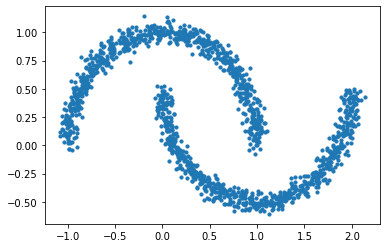

In [3]:
# 创建数据集
X, y = datasets.make_moons(n_samples=1500, noise=.05)
plt.scatter(X[:,0], X[:,1], s=10)

In [4]:
kmeans = KMeans(n_clusters=2)
pred_kmeans = kmeans.fit(X).labels_.astype(np.int)
pred_unnormalized = get_label(X, 2 , 1)
pred_random_walk = get_label(X, 2 , 2)
pred_normalized = get_label(X, 2 , 3)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_10732\4155356410.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_kmeans = kmeans.fit(X).labels_.astype(np.int)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_10732\490836779.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
  s = clf.fit(eigvec.astype(float))  # 聚类
C:\Users\Administrator\AppData\Local\Temp\ipykernel_10732\490836779.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
  s = clf.fit(eigvec.astype(float))  #

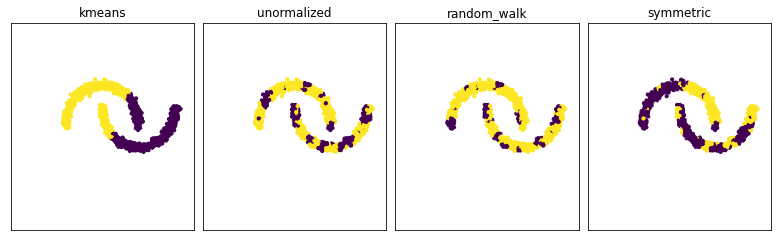

In [5]:
plt.figure(figsize=(4 * 2 + 3, 3))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,hspace=.01)
titles = ['kmeans', 'unormalized', 'random_walk', 'symmetric']
for i, y_pred in enumerate([pred_kmeans,pred_unnormalized ,pred_random_walk, pred_normalized]):
    plt.subplot(1, 4, i+1)
    plt.title(titles[i])
    plt.scatter(X[:, 0], X[:, 1], s=10, c=y_pred)
    plt.xlim(-2.5, 2.5)
    plt.ylim(-2.5, 2.5)
    plt.xticks(())
    plt.yticks(())